In [1]:
import numpy as np
import h5py
from scipy import io
import matplotlib.pyplot as plt
from cfr import task
from cymr import network
import importlib
use_file = '/Users/morton/Dropbox/work/cmr_cfr/cfr/wiki2use/vectors.hdf5'
h5_file = '/Users/morton/Dropbox/work/cmr_cfr/cfr/cfr_patterns.hdf5'

## Write wiki2USE patterns

Read from the vectors file and normalize so that the dot product of each pair of patterns is equal to their correlation. Then write out patterns and pairwise similarity to a standard format HDF5 file.

In [2]:
task.save_patterns_sem(use_file, h5_file)

## Check pattern properties

The general idea is that we want to equate the effect of the context matrix connections and the item connections as much as possible. Context is complicated by integration and the normalization that happens there, plus learning, etc., but we can simplify things by considering the case where an item updates context through w_fc with B=1, then projects to f through w_cf. This means that the activation for item j given cue item i will be equal to the dot product between items i and j.

If we have normalized the patterns, this dot product will be equal to the correlation between items i and j, which is the same as the similarity between i and j in the similarity matrix.

### Individual region patterns

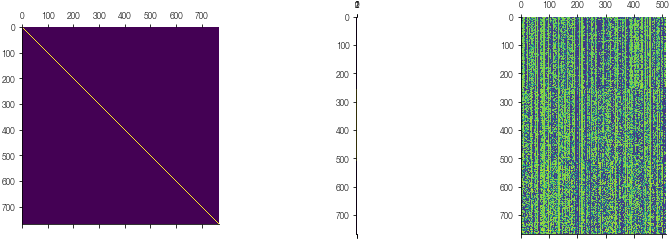

In [3]:
patterns = network.load_patterns(h5_file)

fig, ax = plt.subplots(1, 3, figsize=(12, 4));
ax[0].matshow(patterns['vector']['loc']);
ax[1].matshow(patterns['vector']['cat']);
ax[2].matshow(patterns['vector']['use']);

### Individual region similarity

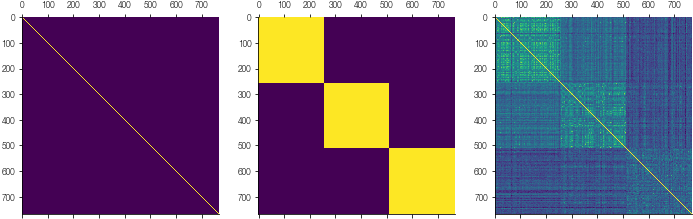

In [4]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4));
ax[0].matshow(patterns['similarity']['loc']);
ax[1].matshow(patterns['similarity']['cat']);
ax[2].matshow(patterns['similarity']['use']);

### Full patterns with weights

To make weighting comparable between the item-item matrix and the item-context-item connections, use the square root of the weight when applying to patterns.

To maintain dot products with the properties we set up originally (e.g., an item with itself is 1), we must divide each weight by the L2 norm over all weights.

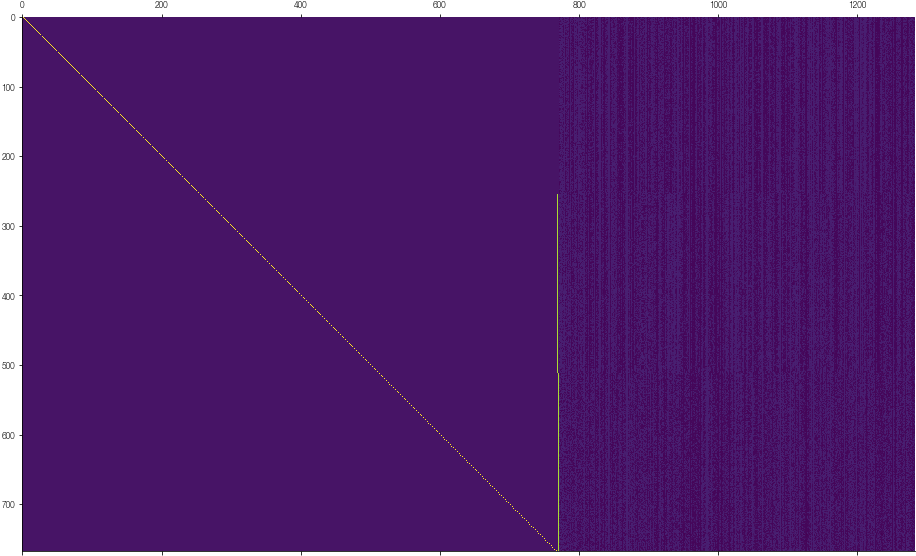

In [5]:
x_list = []
regions = ['loc', 'cat', 'use']
weights = np.array([2, 1.5, 1])
for name, w in zip(regions, weights):
    y = patterns['vector'][name]
    y = y * np.sqrt(w) / np.linalg.norm(np.sqrt(weights), ord=2)
    x_list.append(y)
x = np.hstack(x_list)
fig, ax = plt.subplots(figsize=(16, 12))
ax.matshow(x);

Check that applied weights have the same effect on patterns and similarity matrices. Here, we instead normalize weights using the L1 norm (i.e., dividing by the sum rather than square root of the sum of squares).

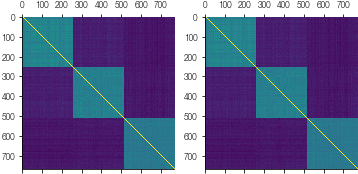

In [6]:
full_sim = np.dot(x, x.T)
sim_weighted = (
    (weights[0] / np.sum(weights)) * patterns['similarity']['loc'] + 
    (weights[1] / np.sum(weights)) * patterns['similarity']['cat'] + 
    (weights[2] / np.sum(weights)) * patterns['similarity']['use']
)

fig, ax = plt.subplots(1, 2);
ax[0].matshow(full_sim);
ax[1].matshow(sim_weighted);

np.testing.assert_allclose(full_sim, sim_weighted, atol=0.0001)

In [7]:
np.testing.assert_allclose(np.linalg.norm(patterns['vector']['loc'], ord=2, axis=1), 1)
np.testing.assert_allclose(np.linalg.norm(patterns['vector']['cat'], ord=2, axis=1), 1)
np.testing.assert_allclose(np.linalg.norm(patterns['vector']['use'], ord=2, axis=1), 1, atol=0.0001)
np.testing.assert_allclose(np.linalg.norm(x, ord=2, axis=1), 1)